In [1]:
import requests
import pandas as pd
import sys
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import PIL
import cv2
import seaborn as sns

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.applications.vgg16 import preprocess_input

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#### Necessary Imports for Neural Net
## Some redundant ones in here too

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# # Helper functions for visualization:

# from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5])

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history, n_epochs):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
    
# # Check balance of labels/data in dataframe

def checkBalance(df):
    all_labels = df['labels']
    all_labels = all_labels.tolist()
    balance = df['labels'].value_counts()
    print(balance)
    for i in range(len(balance)):
        print(f'{balance[i]*100/df.size:.2f} %')

In [3]:
df0 = pd.read_fwf('../PCC_cat.txt', header=None)
# df0[21] # 21 is the label entry index


# # Here we have 7 unique labels:
labels = np.unique(df0[21])

# access ra and dec from their columns in the dataframe
ra = df0[2]
dec = df0[3]

# want only bright objects above r_mag < 19.4  (the magnitude decreases as brightness increases)
bright = np.where(df0[4] <= 19.4)
brightDF = df0.iloc[bright].copy()

labels = np.unique(brightDF[21])

# access ra and dec from their columns in the dataframe
ra = brightDF[2]
dec = brightDF[3]

filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.png'
    filenames.append(fn)

brightDF_reduced = pd.DataFrame({'files' : filenames,
                                 'labels': brightDF[21]})


# checkBalance(brightDF_reduced)
df1 = brightDF_reduced
unique_labels = np.unique(df1['labels'])

clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

downSampleDf0 = pd.concat([clusterBG_LTG, # 384
                         BG_ETG.sample(frac = 400/3008),
                         clusterBG_edgeDisk.sample(frac = 400/1049),
                         likely_dE_ETGcluster, # 398
                         likely_merging, # 23
                         poss_dE_ETGcluster, # 98
                         weak_bg # 477
                         ])
# checkBalance(downSampleDf0)

def replace(df, ind):
    label = list(df['labels'])[0]
    newDf = df.replace(label, str(ind))
    return(newDf)


# combined 3 and 5
second = pd.concat([
                    replace(likely_dE_ETGcluster, 1), # old 3
                    replace(poss_dE_ETGcluster, 1) # old 5
                    ])
# combine 0,1,2,6
first = pd.concat([replace(clusterBG_LTG, 0), # old 0
                   replace(BG_ETG, 0), # old 1
                   replace(clusterBG_edgeDisk, 0), # old 2
                   replace(weak_bg, 0) # old 6
                    ])

lenSecond = len(second.index)
lenFirst = len(first.index)

downSampleDf1 = pd.concat([first.sample(frac = lenSecond/lenFirst), second])

# 0 is background
# 1 is dE/ETGcluster


# remove red contaminants
downFiles = downSampleDf1['files']
redPercent = [None]*len(downFiles)
counter = 0
workDir = '../Images/SDSS-png/'

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 80, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160, 100, 20])
upper2 = np.array([179, 255, 255])

for i, x in enumerate(downFiles):
    testImgPath = os.path.join(workDir, x)
    image = cv2.imread(testImgPath)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # check image for pixels on the lower and upper end of hsv (red is weird for hsv)
    lower_mask = cv2.inRange(image, lower1, upper1)
    upper_mask = cv2.inRange(image, lower2, upper2)
    full_mask = lower_mask + upper_mask;

    result = cv2.bitwise_and(result, result, mask=full_mask)
    dim = np.shape(full_mask)[0] 
    counts = np.count_nonzero(full_mask)
    percent = 100*counts/dim**2
    redPercent[i] = percent
    subtitle_string = f'{percent}% of the image is red'
    filename = testImgPath.split('\\')[-1]

downSampleDf1['reds'] = redPercent # add new column of the red percentage of an image
# downSampleDf1
redList = (downSampleDf1['reds'] >= 50) # percentage threshold of how much red is in the image
# downSampleDf1.shape
df_filtered = downSampleDf1[downSampleDf1['reds'] <= 50]
df_filtered.shape


## Some visualizing snippets
# redInds = np.where(redList)[0] # the indices of the hot pixel images to be removed
# print(len(redInds))
# for n in redInds:
#     red = downSampleDf1['files'].to_list()[n]
#     imStr = 'SDSS-png/' + red
#     im = cv2.imread(imStr)[:,:,::-1] # [:,:,::-1] switches rgb to bgr and vice versa
#     plt.figure
#     plt.imshow(im)
#     plt.show()

(229, 3)

In [4]:
unique_labels

array(['Cluster or background LTG',
       'Likely background ETG or unresolved source',
       'Likely cluster or background edge-on disk galaxy',
       'Likely dE/ETGcluster candidate', 'Likely merging system',
       'Possible dE/ETGcluster candidate',
       'background galaxy with possibly weak substructure'], dtype=object)

In [5]:
brightDF

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
5,NaN,PCC-0006,49.2388,41.4631,19.03,0.00,0.69,0.01,19.28,1.35,...,0.39,-0.11,NaN,NaN,NaN,NaN,Likely merging system,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
6,NaN,PCC-0007,49.2392,41.4215,19.26,0.03,0.97,0.05,20.76,3.79,...,1.02,0.68,0.88,0.66,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
7,NaN,PCC-0008,49.2411,41.4991,18.51,0.01,1.78,0.02,20.95,2.50,...,1.01,0.82,0.93,0.66,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
10,NaN,PCC-0011,49.2420,41.4454,19.19,0.01,1.51,0.02,21.95,1.02,...,0.83,0.59,0.70,0.47,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
25,NaN,PCC-0026,49.2466,41.4451,19.34,0.01,2.04,0.02,21.31,1.20,...,1.18,0.85,0.98,0.75,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,NaN,PCC-5387,49.9985,41.3856,18.60,0.01,2.84,0.06,22.78,2.45,...,0.88,0.70,0.82,0.65,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5407,NaN,PCC-5408,50.0018,41.6806,18.16,0.00,0.16,0.00,15.85,3.30,...,0.24,0.12,NaN,NaN,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5416,NaN,PCC-5417,50.0028,41.3384,18.84,0.01,1.27,0.02,20.74,2.42,...,1.05,0.75,0.78,0.71,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5422,NaN,PCC-5423,50.0040,41.3410,17.50,0.01,1.86,0.02,20.45,4.00,...,0.92,0.76,0.93,0.69,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


In [6]:
# want to clean /rotations-png/test and /rotations-png/train/ every run 
imgDirectory = '../Images/rotations-png'
testPath = os.path.join(imgDirectory,'test','*')
testImgs = glob.glob(testPath)
trainPath = os.path.join(imgDirectory,'train','*')
trainImgs = glob.glob(trainPath)

# testImgs = glob.glob(testDir)
for x in testImgs:
    os.remove(x)
# can't do it all in one loop since in wrong dir
for y in trainImgs:
    os.remove(y)


In [7]:
# # Generate Rotation data

def applyRotations(originalDf, outDir, greyFlag):

    # files and labels as numpy arrays
    files = originalDf['files'].to_numpy()
    label = originalDf['labels'].to_numpy()
    #rotDir = 'rotations'
    rotDir = '../Images/rotations-png'
    originalDir = '../Images/SDSS-png/'
    # rotDir = 'rotations256'

    rotFilenames = list()
    rotLabels = list()

    #angle = [90, 180, 270, 360]
    angle = [30, 45, 60, 90, 120, 135, 150, 180, 210, 225, 240, 270, 300, 315, 330, 360]

    # Use PIL to rotate image on angles in list
    for ang in angle:
        for f, l in zip(files, label):
            imgString = originalDir + f
            im = PIL.Image.open(imgString)
            
            if greyFlag == True:
                im = im.convert('L')
            out = im.rotate(ang)
           
            # generated filename
            outString = f'{rotDir}/{outDir}/{f[:-5]}_rot{ang}_label={l}.png'
            
            # filename relative to working directory
            dfString = f'{outDir}/{f[:-5]}_rot{ang}_label={l}.png'

            out.save(outString)
            rotFilenames.append(dfString)
            rotLabels.append(l)

            rotationDf = pd.DataFrame({'files': rotFilenames,
                                    'labels': rotLabels})

    return(rotationDf)

# # Train/Test Split 

X = df_filtered['files']
y = df_filtered['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

trainDf = pd.DataFrame({'files' : X_train,
                        'labels': y_train})
testDf = pd.DataFrame({'files' : X_test,
                        'labels': y_test})
greyFlag = False
trainDf_rot = applyRotations(trainDf, 'train', greyFlag)
testDf_rot = applyRotations(testDf, 'test', greyFlag)

In [8]:
# checkBalance(trainDf)
checkBalance(trainDf_rot)


0    1424
1    1312
Name: labels, dtype: int64
26.02 %
23.98 %


In [9]:
# # Create datasets with flow from dataframe
IMG_WIDTH = 200
IMG_HEIGHT = 200
TRAIN_BATCH_SIZE = 20
VAL_BATCH_SIZE = 20

#imgDirectory = "./rotations/"
imgDirectory = "../Images/rotations-png/"
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDf_rot,
directory=imgDirectory,
x_col="files",
y_col="labels",
subset="training",
batch_size=TRAIN_BATCH_SIZE, # divisibility
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(IMG_WIDTH,IMG_HEIGHT))

validation_generator=datagen.flow_from_dataframe(
dataframe=trainDf_rot,
directory=imgDirectory,
x_col="files",
y_col="labels",
subset="validation",
batch_size=VAL_BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(IMG_WIDTH,IMG_HEIGHT))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testDf_rot,
directory=imgDirectory,
x_col="files",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(IMG_WIDTH,IMG_HEIGHT))


# # ResNet50 Model
#
# https://github.com/suvoooo/Learn-TensorFlow/blob/master/resnet/Implement_Resnet_TensorFlow.ipynb

def res_identity(x, filters):
    x_skip = x # this will be used for addition with the residual block
    f1, f2 = filters

    #first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)

    # add the input
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def res_conv(x, s, filters):

    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x


def resnet50():

    input_im = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) # cifar 10 images size
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    # here we perform maxpooling, see the figure above

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage

    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage

    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(2, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

Found 2052 validated image filenames belonging to 2 classes.
Found 684 validated image filenames belonging to 2 classes.
Found 928 validated image filenames.


In [10]:
# Old model #
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
#         Dropout(0.5),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
#         Dropout(0.5),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=2, activation='softmax')
    ])
    
    return model

In [11]:
cnn_model = create_model()
# BATCH_SIZE = 1
modelStr = 'pcc_model_1' # template is currently pcc_model_X, where X is the iteration of the model

### Hyperparameters ###
n_epochs = 300
init_lr = 7.5e-2
# init_lr = float(sys.argv[1])
decay_rate = 0.99
# decay_rate = float(sys.argv[2])
decay_steps = 100_000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate = init_lr,
                    decay_steps = decay_steps,
                    decay_rate = decay_rate)


cnn_model.compile(loss='categorical_crossentropy',
                  optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule),
                  metrics = ['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = cnn_model.fit(train_generator,
                        epochs = n_epochs,
                        callbacks = [es],
                        verbose = 1,
                        validation_data=validation_generator)



train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# learning_rate = history.history['']



Epoch 1/300
103/103 [==============================] - 22s 115ms/step - loss: 2.9807 - accuracy: 0.6681 - val_loss: 0.9029 - val_accuracy: 0.4927
Epoch 2/300
103/103 [==============================] - 5s 48ms/step - loss: 0.5442 - accuracy: 0.7471 - val_loss: 0.9084 - val_accuracy: 0.4825
Epoch 3/300
103/103 [==============================] - 5s 48ms/step - loss: 0.4475 - accuracy: 0.8221 - val_loss: 0.6556 - val_accuracy: 0.6272
Epoch 4/300
103/103 [==============================] - 5s 48ms/step - loss: 0.3879 - accuracy: 0.8294 - val_loss: 0.4058 - val_accuracy: 0.8392
Epoch 5/300
103/103 [==============================] - 5s 48ms/step - loss: 0.3665 - accuracy: 0.8504 - val_loss: 0.5766 - val_accuracy: 0.6798
Epoch 6/300
103/103 [==============================] - 5s 48ms/step - loss: 0.3305 - accuracy: 0.8689 - val_loss: 0.2977 - val_accuracy: 0.8904
Epoch 7/300
103/103 [==============================] - 5s 49ms/step - loss: 0.3076 - accuracy: 0.8879 - val_loss: 0.3001 - val_accurac

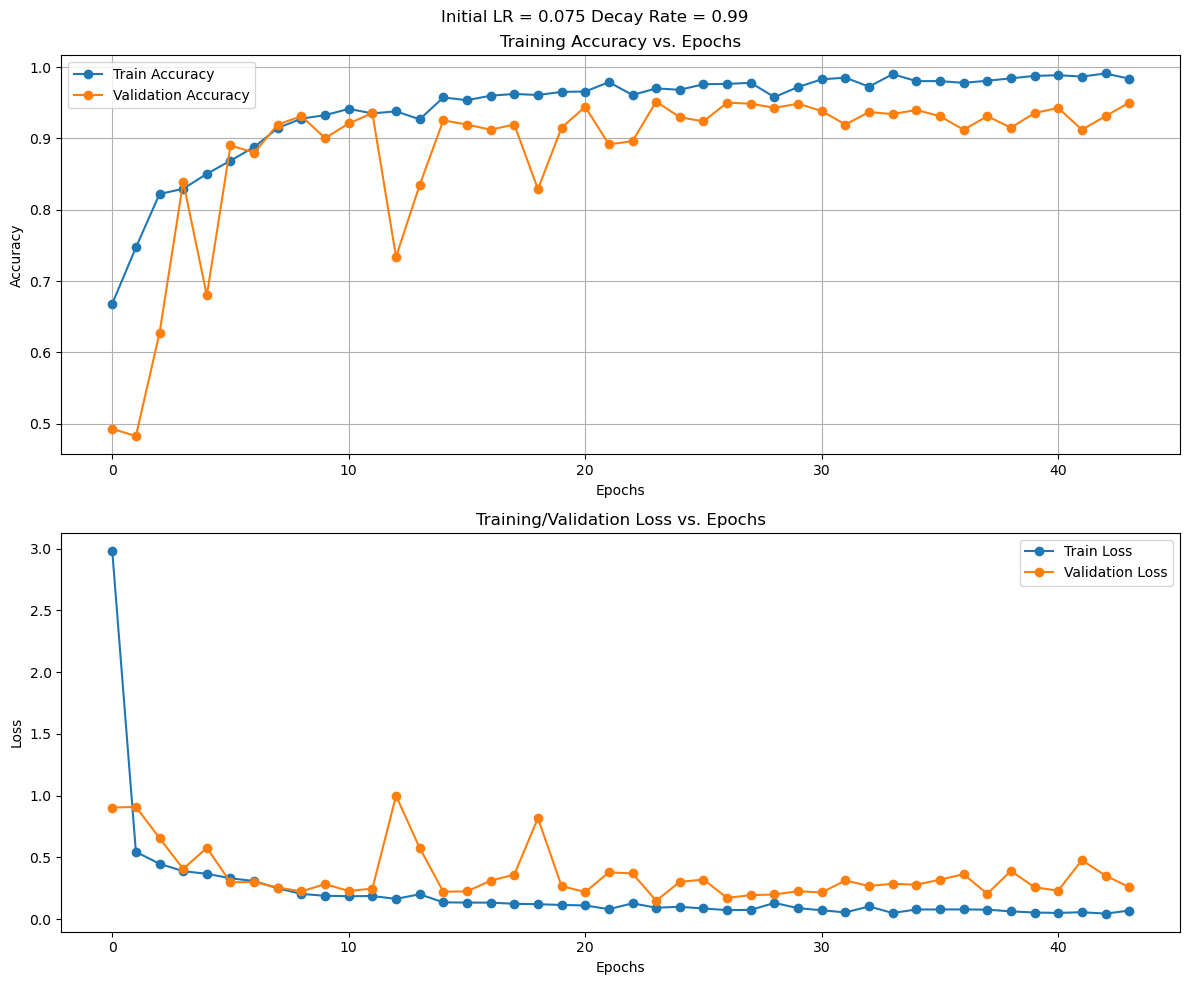

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')
ax[0].grid()

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
# ax[1].set_ylim([-1, 100])
ax[1].legend(loc='best')

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(lr_schedule, 'o-', label='Learning Rate')
# # ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Learning Rate')
# ax[2].legend(loc='best')

# ax[3].set_title('Loss vs learning rate')
# # ax[3].plot(learning_rate, 'o-', label='Learning Rate')
# # ax[3].plot(learning_rate, train_loss, 'o-', label='Train Loss')
# # ax[3].plot(learning_rate, val_loss, 'o-', label='Validation Loss')
# ax[3].plot(lr_schedule, train_loss, 'o-', label='Train Loss')
# ax[3].plot(lr_schedule, val_loss, 'o-', label='Validation Loss')
# ax[3].set_ylabel('Loss')
# ax[3].set_xlabel('Learning Rate')
# ax[3].legend(loc='best')

plt.suptitle(f'Initial LR = {init_lr} Decay Rate = {decay_rate}')
plt.tight_layout()
plt.savefig(f'../Images/{modelStr}-train-report_init-lr={init_lr}_decay-rate={decay_rate}.png')
plt.show()


# fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
# idx = 0

# for i in range(2):
#     for j in range(5):
#         predicted_label = unique_labels[np.argmax(predictions[idx])]
#         ax[i, j].set_title(f"{predicted_label}", fontsize=10)
#         ax[i, j].imshow(test_generator[idx][0])

#         ax[i, j].axis("off")
#         idx += 1

# # plt.tight_layout()
# plt.suptitle("Test Dataset Predictions", fontsize=20)
# plt.show()


# In[34]:

In [13]:
predictions = cnn_model.predict(test_generator)
test_loss, test_accuracy = cnn_model.evaluate(validation_generator, batch_size=1) # needs to be divisible

y_pred = np.argmax(predictions, axis=1)
y_true = testDf_rot['labels'] # this needs to be checked if you change the input dataframes
y_true = y_true.tolist()
# len(y_pred) == len(y_true)
unique_labels = {value: key for key, value in train_generator.class_indices.items()}

# print("Label Mappings for classes present in the training and validation datasets\n")
# for key, value in unique_labels.items():
#     print(f"{key} : {value}")

# function to return key for any value
def get_key(val):
    for key, value in unique_labels.items():
        if val == value:
            return key

    return "key doesn't exist"

Y_true = []
# for i in range(len(y_true)): # This was the original way to do it -- be careful, this only solved a mismatch and could be wrong
for i in range(len(y_pred)):
    Y_true.append(get_key(y_true[i]))

cf_mtx = confusion_matrix(Y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)


# cf_mtx.sum()

y_true = np.array([int(x) for x in y_true]) # cast to np array for type consistency with y_pred
errors = (y_true - y_pred != 0) # everywhere the numbers don't match
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

test_images = test_generator.filenames
test_img_err = np.asarray(test_images)[errors]


# fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12, 10))
# idx = 0

hits = (y_true - y_pred == 0)
y_true_hits = y_true[hits]
y_pred_hits = y_pred[hits]

test_img_hits = np.asarray(test_images)[hits]

35/35 [==============================] - 1s 23ms/step - loss: 0.1481 - accuracy: 0.9518


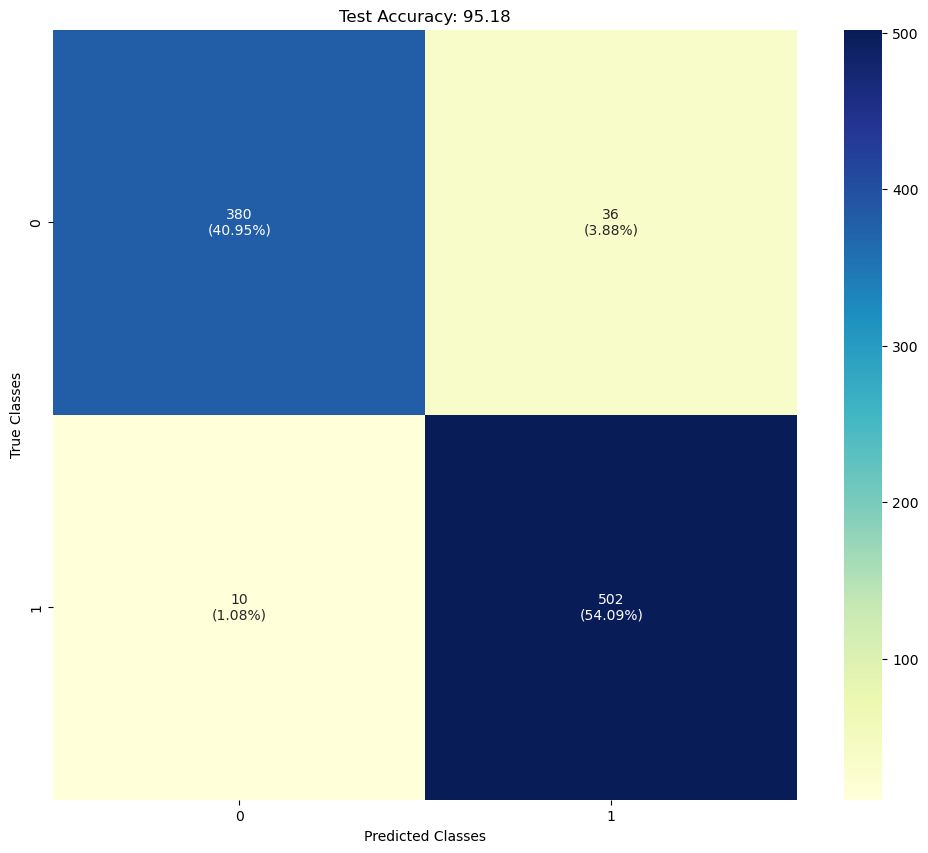

Init conds:
init lr: 0.075, decay rate: 0.99, decay steps: 100000
Test Loss:     0.14813926815986633
Test Accuracy: 0.9517543911933899


In [14]:
plt.figure(figsize = (12, 10))
# sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
#            cmap="YlGnBu", fmt="", annot=box_labels)
sns.heatmap(cf_mtx, cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
#plt.show()

plt.title(f"Test Accuracy: {test_accuracy*100:.2f}")
plt.savefig(f'../Images/{modelStr}-confusion-matrix_init-lr={init_lr}_decay-rate={decay_rate}_offrots.png')

# for i in range(3):
#     for j in range(5):
#         idx = np.random.randint(0, len(test_img_err))
#         true_index = y_true_errors[idx]
#         true_label = unique_labels[true_index]
#         predicted_index = y_pred_errors[idx]
#         predicted_label = unique_labels[predicted_index]
#         ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
#         ax[i, j].imshow(test_generator[idx][0])
#         ax[i, j].axis("off")

# plt.tight_layout()
# plt.suptitle('Wrong Predictions made on test set', fontsize=15)
# plt.show()


# fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12, 10))
# idx = 0

# for i in range(3):
#     for j in range(5):
#         idx = np.random.randint(0, len(test_img_hits))
#         true_index = y_true_hits[idx]
#         true_label = unique_labels[true_index]
#         predicted_index = y_pred_hits[idx]
#         predicted_label = unique_labels[predicted_index]
#         ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
#         ax[i, j].imshow(test_generator[idx][0])
#         ax[i, j].axis("off")

# plt.tight_layout()
# plt.suptitle('True Predictions made on test set', fontsize=15)
plt.show()

# # End result:
print(f'Init conds:')
print(f'init lr: {init_lr}, decay rate: {decay_rate}, decay steps: {decay_steps}')
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
cnn_model.save(f'../Models/{modelStr}.h5')


In [15]:
conv_layers = [None]*len(cnn_model.layers) # 53 was resnet50
ind = 0
for layer in cnn_model.layers:
    
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
        
    else:
        # get filter weights
        filters, biases = layer.get_weights()
        print(layer.name, filters.shape, layer.output.shape)
        conv_layers[ind] = layer.name
        ind += 1
len(conv_layers)

conv2d (5, 5, 3, 128) (None, 196, 196, 128)
conv2d_1 (3, 3, 128, 64) (None, 96, 96, 64)
conv2d_2 (3, 3, 64, 32) (None, 46, 46, 32)


16

In [16]:
filters, biases = cnn_model.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

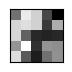

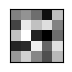

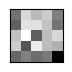

In [17]:
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    
# plot each channel separately
for j in range(3):
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, j], cmap='gray')
    ix += 1
    # show the figure
    plt.show()

In [18]:
## are these redundant?? TODO -- Clean!

trainPath = os.path.join('../Images/rotations-png', 'train', '*')
trainImgs = glob.glob(trainPath)
testPath = os.path.join('../Images/rotations-png', 'test', '*')
testImgs = glob.glob(testPath)

maps_model = Model(cnn_model.inputs, outputs=cnn_model.layers[1].output)
# maps_model.summary()
exImage = load_img(testImgs[0])
copyImg = exImage.copy()
exImage = img_to_array(exImage)
exImage = np.expand_dims(exImage, axis = 0)
exImage = preprocess_input(exImage)

feature_maps = maps_model.predict(exImage)
# feature_maps
# np.shape(exImage)

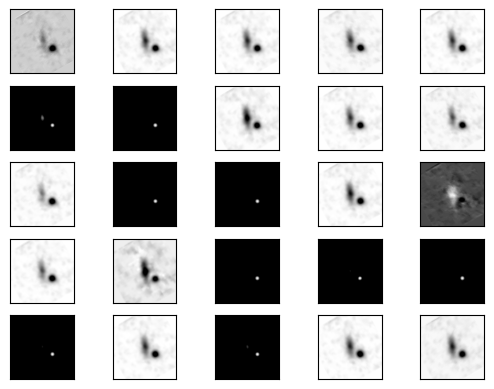

In [19]:
square = 5
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
#         plt.imshow((feature_maps[0, :, :, ix-1]))
        ix += 1
# show the figure
plt.show()

Text(0.5, 1.0, '../Images/rotations-png\\test\\sdss_ra=49.2466_dec=41.445_rot120_label=0.png')

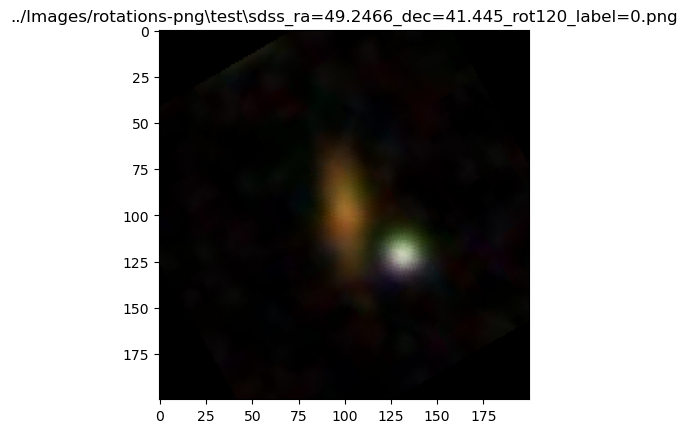

In [20]:
plt.imshow(copyImg)
plt.title(testImgs[0])